# IEEE-CIS Fraud Detection Modeling 


<font size="5">[kaggle](https://www.kaggle.com/competitions/ieee-fraud-detection/overview/description)</font>


## 개요(Overview)

[Description](https://www.kaggle.com/competitions/ieee-fraud-detection/overview/description)

**실제 상거래 데이터에서 이상거래를 탐지** <br>
이상 거래라고 하면 일반적인 **binary classification 문제**와 가장 크게 다른 점이라고 한다면 **타겟 불균형**이 되겠습니다. 그래서 보통 over/under sampling 기법을 활용하기도 하고 요즘엔 **unsupervised learning을 활용**한 방법도 많이 나와있습니다.


**Evaluation**
- ROC curve
- TransactionID(PK) 
- isFraud (**Target, 사기 거래일 확률 예측**)

[Link](https://www.kaggle.com/code/datasoin/eda-team-o/notebook?scriptVersionId=74651045)!! -> 참고함

[참고자료]
1. [EDA and models](https://www.kaggle.com/code/artgor/eda-and-models) # 인강 내용  <br>
2. [Extensive EDA and Modeling XGB Hyperopt](https://www.kaggle.com/code/kabure/extensive-eda-and-modeling-xgb-hyperopt)
3. [blog](https://slowsteadystat.tistory.com/19)
    1. [Winning solutions listed](https://www.kaggle.com/c/ieee-fraud-detection/discussion/111252)
    2. [1st Place Solution](https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308) <br>
        1. [Short Summary](https://www.kaggle.com/c/ieee-fraud-detection/discussion/111257#latest-641140) <br>
        2. EDA
         - NaN과 상관있는 변수 탐색, 변수 간 corr(이 후 feature selection에 활용
        3. Feature Selection
         - forward feature selection (using single or groups of features)
         - recursive feature elimination (using single or groups of features)
         - permutation importance
         - adversarial validation
         - correlation analysis
         - time consistency
         - client consistency
         - train/test distribution analysis

## 필요한 라이브러리와 데이터를 불러오기

In [2]:
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np   # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

In [3]:
base_path = '/Users/goeun/Documents/YearDream/MiniProJect/6월_ML/ieee-fraud-detection/mini_pjt_modeling/project/data/raw/'

train = pd.read_csv(base_path + 'train.csv')
test = pd.read_csv(base_path + 'test.csv')
submission = pd.read_csv(base_path + 'sample_submission.csv')

In [4]:
# shape 확인
train.shape, test.shape, submission.shape

((590540, 434), (506691, 433), (506691, 2))

In [6]:
# total cells
np.product(train.shape),np.product(test.shape), np.product(submission.shape)

(256294360, 219397203, 1013382)

## EDA

<font size="4">fraud detection data describe</font>

주 데이터는 identity 와 transaction으로 나뉘며, TransactionID을 공통분모를 가짐

**1. train_transaction Table : 거래 관련**<br>

| Column Name | Description | Dtype |
| ----------- | ----------- |-----|
| TransactionID|고유값, PK|int64 |
|isFraud|사기 거래 수(``traget``)|int64(binary)|
|TransactionDT|주어진 참조 datetime의 timedelta(실제 타임스탬프가 아님), 초단위|int64|
| TransactionAMT|거래 결제 금액(USD)|float64 |
| ProductCD| 제품 코드, 각 거래에 대한 제품|object|
| card1 - card6| 카드 종류, 카드 종류, 발행 은행, 국가 등의 결제 카드 정보|``int64`` or ``float64`` or ``object``|
| addr|주소|float64|
| dist|거리|float64|
| P_ and (R__) emaildomain| 구매자 및 수신자 이메일 도메인|object|
| C1-C14|지불 카드와 연결된 것으로 확인된 주소 수 등의 계산. 실제 의미는 가려져 있습니다.|float64|
| D1-D15|이전 트랜잭션 사이의 날짜 등과 같은 timedelta|float64|
| M1-M9|카드의 이름 및 주소 등과 같은 일치|object|
| Vxxx|Vesta는 순위, 계산 및 기타 엔터티 관계를 포함하여 풍부한 기능을 엔지니어링했습니다.|float64|

> **Categorical Features**  <br>
ProductCD <br>
card1 - card6 <br>
addr1, addr2 <br>
P_emaildomain <br>
R_emaildomain <br>
M1 - M9

**2. train_id Table : 접근 환경 관련**
네트워크 연결정보(IP, ISP, Proxy 등) <br>
트랜잭션과 관련된 디지털 서명(UA/브라우저/os/버전 등)<br>
id01 ~ id11은 기기 등급, ip_domain 등급, 프록시 등급 등 Vesta와 보안 파트너가 수집하는 신원에 대한 숫자 기능입니다. 또한 계정 로그인 횟수/로그인 실패 횟수, 계정 기간과 같은 행동 지문을 기록했습니다. 페이지에 머물렀다 등. 

> **Categorical Features** <br>
DeviceType <br>
DeviceInfo <br>
id_1 - id_38

**train = train_id + train_transaction, merge(left)**

### train 데이터 확인

In [7]:
# print(train.info(verbose=True, null_counts=True))

display(train.head(2))
display(train.tail(2))

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return
resumetable(train)[46:70]

Dataset Shape: (590540, 435)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
46,M1,object,271100,2,T,NaN,T,0.00
47,M2,object,271100,2,T,NaN,T,0.49
48,M3,object,271100,2,T,NaN,T,0.75
49,M4,object,281444,3,M2,M0,M0,1.31
50,M5,object,350482,2,F,T,F,0.99
51,M6,object,169360,2,T,T,F,1.00
52,M7,object,346265,2,NaN,NaN,F,0.57
53,M8,object,346252,2,NaN,NaN,F,0.95
54,M9,object,346252,2,NaN,NaN,F,0.63
55,V1,float64,279287,2,1.0,NaN,1.0,0.00


In [9]:
# print(train_transaction.columns)
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


#### traget plot

In [39]:
train.isFraud.isna().sum()

0

0    569877
1     20663
Name: isFraud, dtype: int64


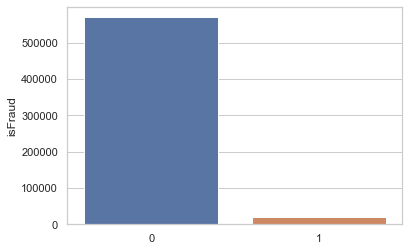

In [40]:
print(train.isFraud.value_counts())

sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x = train.isFraud.value_counts().index, y = train.isFraud.value_counts(), data=train)

traget의 편차가 큼(타켓 불균형)

In [41]:
# 샘플데이터 500 Fraud adn 500 Non Fraud sampled_train 저장
sampled_train = pd.concat([train.loc[train['isFraud'] == 0 ].sample(500),
                         train.loc[train['isFraud'] == 1].sample(500)])
sampled_train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
201645,3188645,0,4590201,50.000,H,6054,327.0,150.0,discover,NaN,...,chrome 63.0 for android,32.0,1920x1080,match_status:2,T,F,T,T,mobile,SM-G930T Build/NRD90M
497262,3484262,0,13028481,50.000,R,18268,583.0,150.0,visa,226.0,...,mobile safari generic,32.0,2436x1125,match_status:1,T,F,F,F,mobile,iOS Device
468058,3455058,0,12069509,527.000,W,7919,194.0,150.0,mastercard,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563677,3550677,0,14934888,57.950,W,5017,432.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93604,3080604,0,1948468,55.950,W,4436,174.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508689,3495689,1,13314825,35.044,C,2870,555.0,119.0,mastercard,224.0,...,chrome generic,NaN,NaN,NaN,F,F,T,F,desktop,SM-A300M Build/KTU84P
257174,3244174,1,6162605,300.000,R,15063,514.0,150.0,visa,226.0,...,chrome 63.0,24.0,1366x768,match_status:2,T,F,T,F,desktop,Windows
408023,3395023,1,10298634,31.418,C,10086,500.0,185.0,mastercard,224.0,...,chrome 65.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows
319152,3306152,1,7937456,200.000,H,9749,181.0,150.0,visa,226.0,...,samsung browser generic,32.0,1920x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G891A Build/NRD90M


In [ ]:
# sns.displot(train)

#### 결측치  확인

In [13]:
train.isna().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 434, dtype: int64

In [14]:
total_missing = train.isna().sum()
print("% of total missing data = ",(total_missing.sum()/np.product(train.shape))*100)

% of total missing data =  45.074371905803936


<AxesSubplot:>

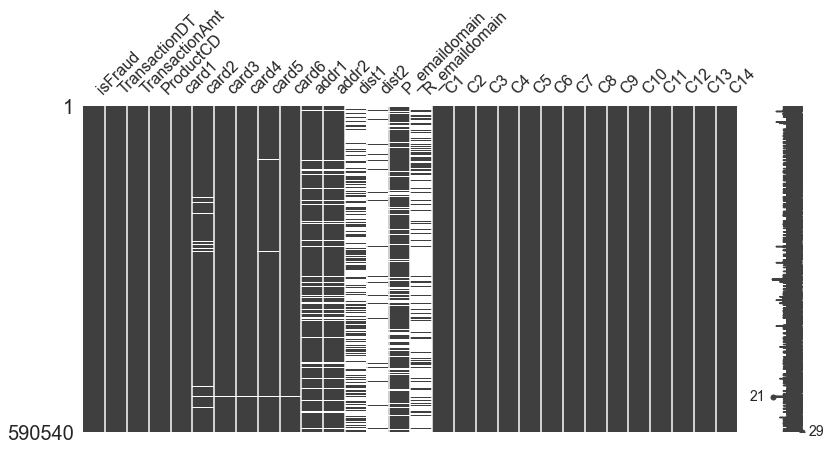

In [12]:
# 훈련 데이터 결측값 시각화 1
msno.matrix(df = train.iloc[:,1:31], figsize=(13,6))

오른쪽 막대는 결측값의 상대적인 분포, 뾰족하게 튀어나온 부분이 결측값이 몰려있는 행 의미, 왼쪽에 표시된 21는 결측값이 없는 열의 개수, 오른쪽의 29는 전체 열의 개수를 나타냄

In [15]:
print(round(20663/(569877+20663)*100,3),'% of Transactions that are fraud in train.')

3.499 % of Transactions that are fraud in train.


위 표에서 볼 수 있듯이 사기 거래인 데이터는 전체의 약 3.5%에 못 미치며 데이터 불균형을 초래하고 있다. <br>
또한 데이터에 대한 이슈는 아래에서 계속 찾아볼 수 있는데, Train data와 Test data 사이 시간적 공백이 존재한다는 것이다.¶

#### TransactionDT

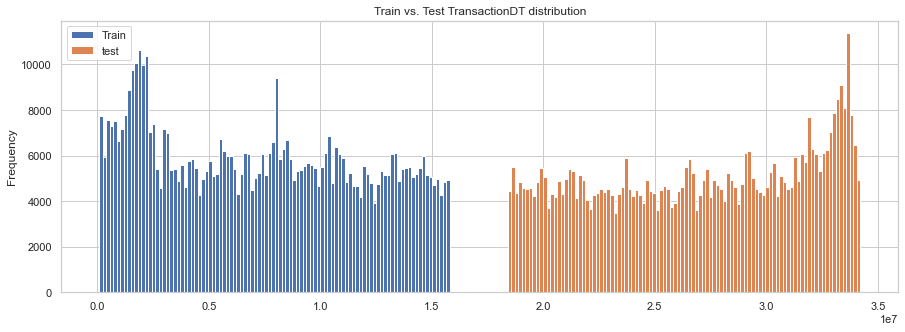

In [16]:
train['TransactionDT'].plot(kind='hist', figsize=(15,5), bins=100, label='Train', title='Train vs. Test TransactionDT distribution')
test['TransactionDT'].plot(kind='hist', label='test', bins=100)
plt.legend()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


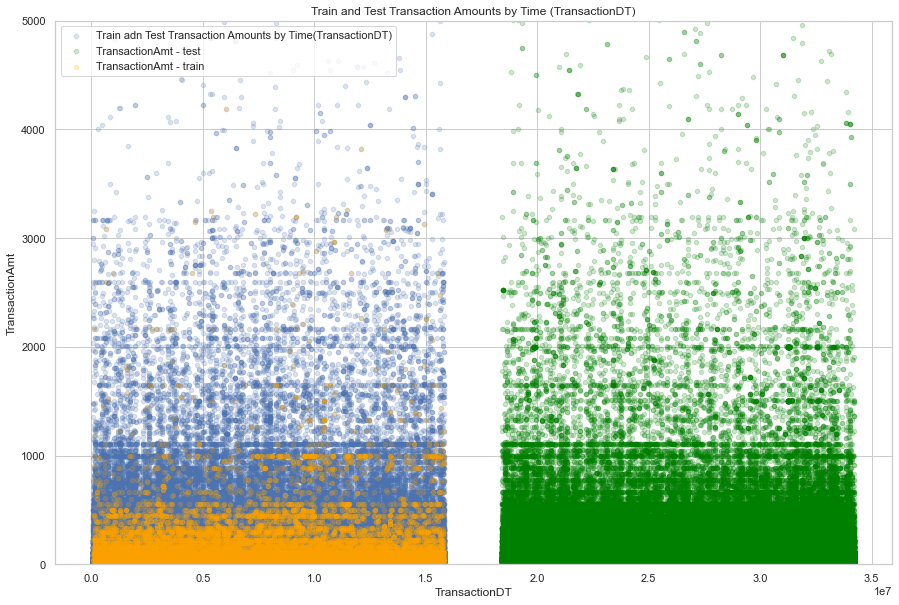

In [18]:
# 전체 분포
ax = train.plot(x = 'TransactionDT' ,
                            y = 'TransactionAmt',
                            kind = 'scatter',
                            alpha = 0.2,
                            label = 'Train adn Test Transaction Amounts by Time(TransactionDT)',
                            ylim = (0, 5000),
                            figsize=(15,10)
                            ) ;

# test 트랜잭션 분포
test.plot(x = 'TransactionDT',
                      y = 'TransactionAmt',
                      kind = 'scatter',
                      label = 'TransactionAmt - test',
                      alpha = 0.2,
                      color = 'green',
                      ylim = (0, 5000),
                      ax = ax) ;

# 학습 트랜잭션 중 사기인 것들 분포
# Plot Fraud as Orange
train.loc[train['isFraud'] == 1].plot(
                                                                x = 'TransactionDT',
                                                                y = 'TransactionAmt',
                                                                kind = 'scatter',
                                                                alpha = 0.2,
                                                                label = 'TransactionAmt - train',
                                                                title = 'Train and Test Transaction Amounts by Time (TransactionDT)',
                                                                ylim = (0, 5000),
                                                                color = 'orange',
                                                                figsize = (15, 10),
                                                                ax = ax
                                                             ) ;

plt.show()

####  feature new 'Time'

Train과 Test 사이 공백을 구해보자.
The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).
TransactionDT feature는 주어진 날짜(시간)간의 연산이 가능한 timedelta.

[The timespan of the dataset is 1 year ?](https://www.kaggle.com/c/ieee-fraud-detection/discussion/100071#latest-577632) by Suchith
를 참고하여 이 공백이 약 30일, 한달 정도를 의미한다는 것을 알 수 있었다.

>Train: min = 86400 max = 15811131 <br>
Test: min = 18403224 max = 34214345

If it is in seconds then dataset timespan will be `x/(3600*24*365) = 1.0821` years which seems reasonable to me. So if the **transactionDT** is in **seconds** then

> Time span of the total dataset is 394.9993634259259 days <br>
Time span of Train dataset is  181.99920138888888 days<br>
Time span of Test dataset is  182.99908564814814 days<br>
The gap between train and test is 30.00107638888889 days

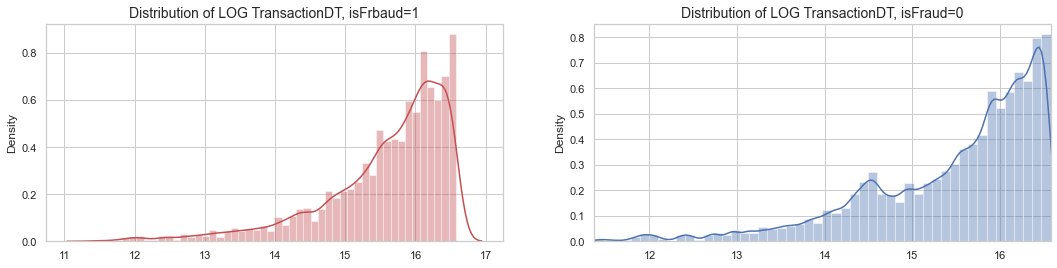

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train.loc[train['isFraud'] == 1]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionDT, isFrbaud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train.loc[train['isFraud'] == 0]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

더 자세히 들여다 보기 위해 0과 1 사이에 있는 value를 음수로 만들기 위해 log를 씌우고, TransactionDT의 최소부터 최대까지를 범위로 하는 그래프 <br>
사기 거래의 경우, 사기가 이루어진 어느 시점의 이후 더이상 접속하지 않는다는 것을 알 수 있음.

In [46]:
# 시간(3600초: 1시간)
train['TransactionHr'] = ((train.TransactionDT/3600)%24).astype(int)
train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionHr
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23


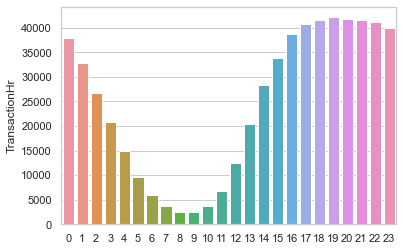

In [47]:
# time data : 정확한 시간은 아님 초를 시간으로 나타냄
# print(train_transaction.TransactionHr.value_counts().sort_index())
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x = train.TransactionHr.value_counts().index, y = train.TransactionHr.value_counts(), data=train)

#### 시간대별 사기 건수

In [48]:
fraud_hr = train.groupby(['TransactionHr','isFraud'])['TransactionHr','isFraud'].count()['TransactionHr']
fraud_hr = pd.DataFrame(fraud_hr)
fraud_hr.columns = ['count']
fraud_hr

count
TransactionHr isFraud       
0             0        36609
              1         1186
1             0        31770
              1         1027
2             0        25730
              1         1002
3             0        20005
              1          797
4             0        14069
              1          770
5             0         9019
              1          682
6             0         5540
              1          467
7             0         3311
              1          393
8             0         2350
              1          241
9             0         2256
              1          223
10            0         3434
              1          193
11            0         6562
              1          265
12            0        12072
              1          379
13            0        19850
              1          465
14            0        27642
              1          686
15            0        32999
              1          860
16            0        37556
              1         1142
17            0        39439
              1         1284
18            0        40172
              1         1467
19            0        40652
              1         1463
20            0        40350
              1         1432
21            0        40225
              1         1416
22            0        39794
              1         1345
23            0        38471
              1         1478

```
# 오래걸림
ax = train_transaction.plot(kind='bar', title='시간대별 isFraud개수', figsize=(12, 4), legend=True, fontsize=12)
ax.set_xlabel('TransactionHr', fontsize=12)          # x축 정보 표시
ax.set_ylabel('isFraud', fontsize=12)     # y축 정보 표시
ax.legend(['0', '1'], fontsize=12)    # 범례 지정
```

#### 시간대별 결재금액의 사기 건 수

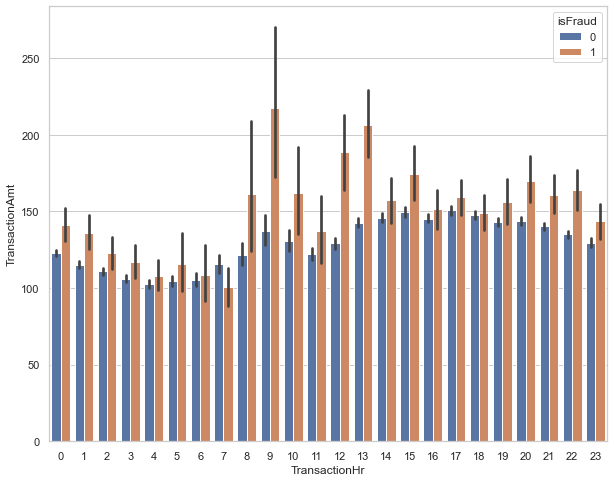

In [49]:
plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="TransactionHr", y="TransactionAmt", hue = "isFraud", data=train)

8~13 까지의 isFraud가 1일 때 신뢰구간이 넓어 통계적 유효성이 떨어짐

#### TransactionAmt

Mean transaction amt for fraud is 149.2448 <br>
Mean transaction amt for non-fraud is 134.5117

사기 금액이 전체 거래 금액에 비해 높음

In [24]:
train.TransactionAmt.isna().sum()

0

In [26]:
# mean = 135
print(len(train[train.TransactionAmt > 135]))
# train_transaction.loc[(train_transaction.TransactionAmt > 135) & (train_transaction.isFraud == 0)] # 134670, 96%
train.loc[(train.TransactionAmt > 135) & (train.isFraud == 1)] # 6317, 4.5%

140987


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
203,2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,...,chrome 62.0 for ios,NaN,NaN,NaN,F,F,F,F,mobile,NaN
367,2987367,1,92350,225.000,R,4425,562.0,150.0,mastercard,197.0,...,firefox,24.0,1440x900,match_status:2,T,F,T,F,desktop,rv:52.0
923,2987923,1,108912,774.000,W,5033,269.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1081,2988081,1,117398,2161.000,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590308,3577308,1,15806122,934.000,W,10486,514.0,150.0,mastercard,219.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590327,3577327,1,15806478,934.000,W,10486,514.0,150.0,mastercard,219.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590347,3577347,1,15807005,450.000,H,6872,587.0,150.0,visa,226.0,...,chrome 65.0,24.0,1600x1200,match_status:2,T,F,T,T,desktop,Windows
590361,3577361,1,15807368,1224.000,W,3278,453.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
min(train.TransactionAmt), max(train.TransactionAmt)

(0.251, 31937.391)

In [28]:
train[train.TransactionAmt > 5000]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
119566,3106566,0,2330164,5094.950,W,6019,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171451,3158451,0,3704698,5278.950,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248413,3235413,0,5926506,6085.230,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274336,3261336,0,6652360,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274339,3261339,0,6652391,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275529,3262529,0,6706260,5420.000,W,5033,269.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275535,3262535,0,6706356,5420.000,W,5033,269.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296021,3283021,0,7320188,6450.970,W,16661,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303106,3290106,0,7501413,5279.950,W,12583,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315172,3302172,0,7850500,5279.950,W,11106,100.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
train[train.TransactionAmt > 30000]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
274336,3261336,0,6652360,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274339,3261339,0,6652391,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
print('Mean transaction amt for fraud is {:.4f}'\
      .format(train.loc[train.isFraud == 1] ['TransactionAmt'].mean()))
print('Mean transaction amt for non - fraud is {:.4f}'.format(train.loc[train.isFraud == 0] ['TransactionAmt'].mean()))

Mean transaction amt for fraud is 149.2448
Mean transaction amt for non - fraud is 134.5117


#### ProductCD

제품코드에 대해 알 수 있는 것들 <br>
각각이 어떤 제품을 대표하는 제품코드인지는 알 수 없으나, <br>
- W 가 제일 많은 수로 구매한 제품 코드이고, S 가 제일 적은 수로 구매한 제품코드이다.
- productCD C 는 동 제품코드 전체의 11% 이상에서 사기 거래 비율을 차지한다.
- productCD W 는 동 제품코드 전체의 2% 이하의 사기 거래 비율이 나타난다.

In [52]:
train.ProductCD.unique()

array(['W', 'H', 'C', 'S', 'R'], dtype=object)

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64


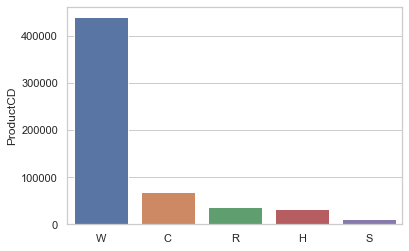

In [53]:
print(train.ProductCD.value_counts())

sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x = train.ProductCD.value_counts().index, y = train.ProductCD.value_counts(), data=train)

In [54]:
# 오래걸림 
# fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# fig.suptitle('Fraud by ProductCD')

# sns.barplot(ax=axes[0], x = train_transaction.ProductCD.index, y = train_transaction.isFraud.values)
# axes[0].set_title(train_transaction.ProductCD.name)

# sns.barplot(ax=axes[1], x = train_transaction.ProductCD.index, y = train_transaction.isFraud.values, hue = "isFraud")
# axes[1].set_title(charmander.name)

ProductCD
W    0.020399
R    0.037826
H    0.047662
S    0.058996
C    0.116873
Name: isFraud, dtype: float64


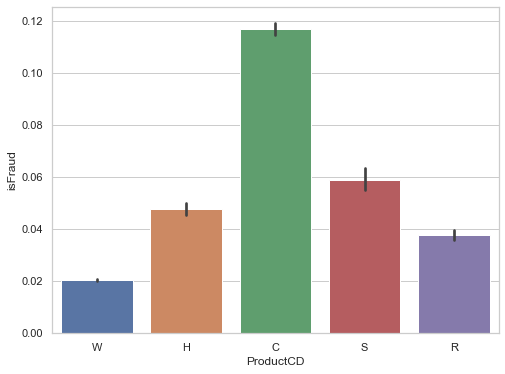

In [55]:
print(train.groupby('ProductCD')['isFraud'].mean().sort_values())

plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="ProductCD", y="isFraud", data=train)

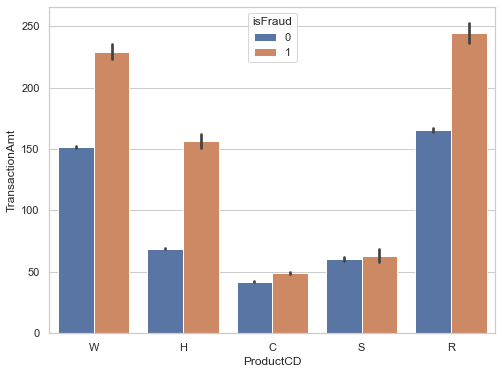

In [57]:
plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="ProductCD", y="TransactionAmt", hue = "isFraud", data=train)

----


#### Card

In [30]:
card = train.iloc[:,5:11]
card

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit
...,...,...,...,...,...,...
590535,6550,NaN,150.0,visa,226.0,debit
590536,10444,225.0,150.0,mastercard,224.0,debit
590537,12037,595.0,150.0,mastercard,224.0,debit
590538,7826,481.0,150.0,mastercard,224.0,debit


In [38]:
(card.isna().sum()/len(train))*100

card1    0.000000
card2    1.512683
card3    0.265012
card4    0.267044
card5    0.721204
card6    0.266028
dtype: float64

In [32]:
card.card4.unique()

array(['discover', 'mastercard', 'visa', 'american express', nan],
      dtype=object)

In [37]:
# card4 결측치 & 사기 거래 수
len(train[(train.card4.isna())&(train.isFraud == 1)])

41

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64


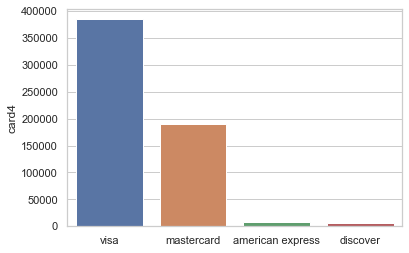

In [35]:
print(train.card4.value_counts())

sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x = train.card4.value_counts().index, y = train.card4.value_counts(), data=train)

#### addr, dist, P_ and (R__) emaildomain

In [42]:
train.iloc[:,11:17]

,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
0,315.0,87.0,19.0,NaN,NaN,NaN
1,325.0,87.0,NaN,NaN,gmail.com,NaN
2,330.0,87.0,287.0,NaN,outlook.com,NaN
3,476.0,87.0,NaN,NaN,yahoo.com,NaN
4,420.0,87.0,NaN,NaN,gmail.com,NaN
...,...,...,...,...,...,...
590535,272.0,87.0,48.0,NaN,NaN,NaN
590536,204.0,87.0,NaN,NaN,gmail.com,NaN
590537,231.0,87.0,NaN,NaN,gmail.com,NaN
590538,387.0,87.0,3.0,NaN,aol.com,NaN


In [43]:
train.iloc[:,11:17].isna().sum()

addr1             65706
addr2             65706
dist1            352271
dist2            552913
P_emaildomain     94456
R_emaildomain    453249
dtype: int64

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

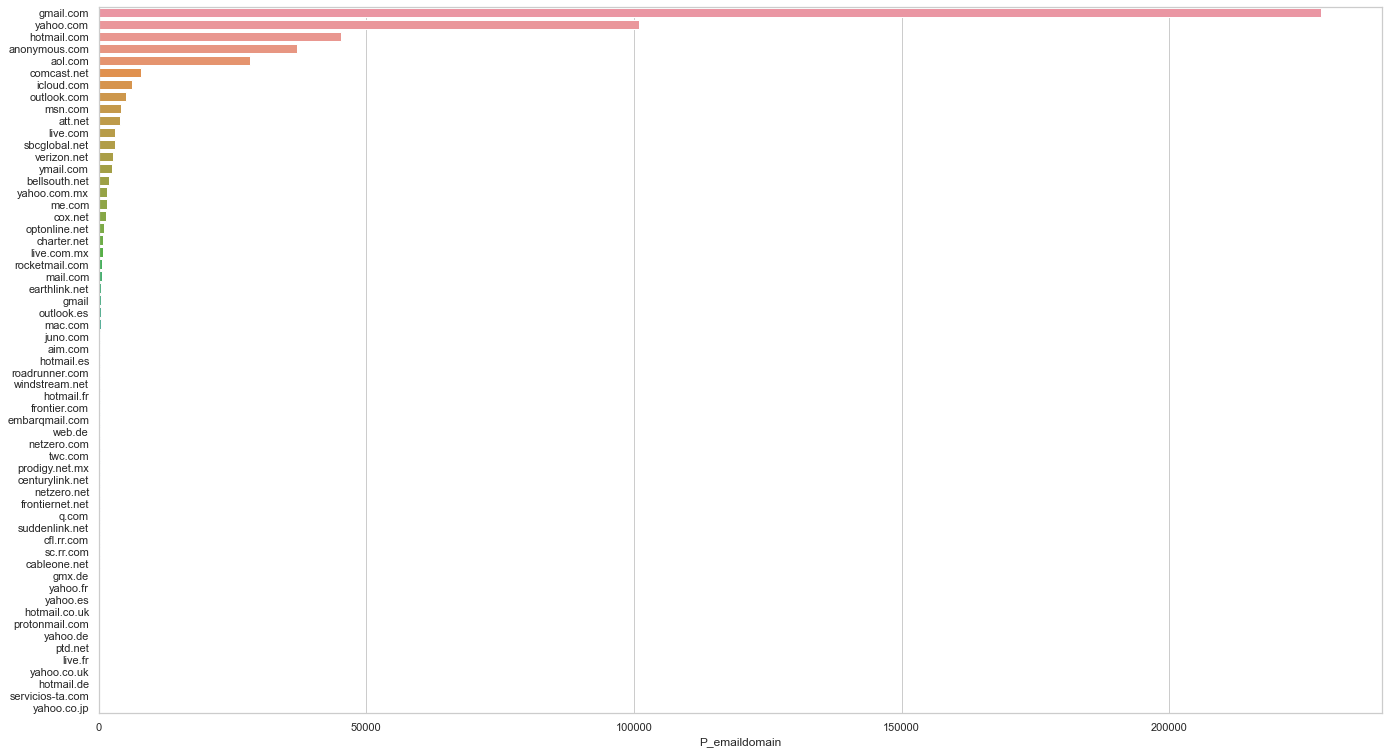

In [60]:
print(train.P_emaildomain.value_counts())

plt.figure(figsize=(23,13))
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x = train.P_emaildomain.value_counts(), y = train.P_emaildomain.value_counts().index, data=train, orient='h')

#### C1~C14 : 지불 카드와 연결된 주소  수 등의 계산, 실제 의미 마스킹 -> 결측치 X

In [61]:
c_cols = [c for c in train if c[0] == 'C']
train[c_cols].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215
std,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,3.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,12.000000,2.000000
max,4685.000000,5691.000000,26.000000,2253.000000,349.000000,2253.000000,2255.000000,3331.000000,210.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


In [62]:
train[c_cols]

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0
590536,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
590537,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
590538,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0


#### D1 ~ D15 (이전 거래 사이의 날짜 등과 같은 timedelta로 NaN 값인 것을 확인할 수 있다)

<AxesSubplot:>

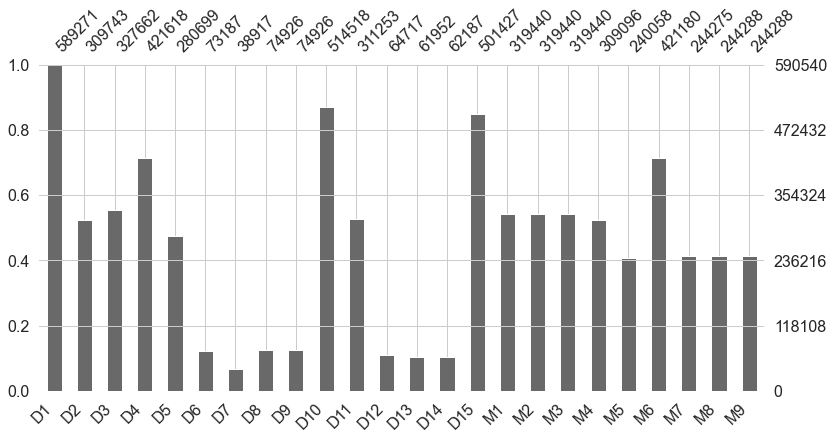

In [75]:
# 훈련 데이터 결측값 시각화 2 (D,M)
msno.bar(df = train.iloc[:,31:55], figsize=(13,6))

In [76]:
d_cols = [d for d in train if d[0] == 'D']
train[d_cols]

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,DeviceType,DeviceInfo
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,NaN,NaN
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,NaN,NaN
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,NaN,NaN,NaN,56.0,NaN,NaN
590536,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
590537,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
590538,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,NaN,NaN,NaN,22.0,NaN,NaN


In [77]:
train[d_cols].describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
count,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000
mean,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,163.744579
std,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,202.726660
min,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,-83.000000
25%,0.000000,26.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.958333,0.208333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,97.000000,8.000000,26.000000,10.000000,0.000000,0.000000,37.875000,0.666666,15.000000,43.000000,0.000000,0.000000,0.000000,52.000000
75%,122.000000,276.000000,27.000000,253.000000,32.000000,40.000000,17.000000,187.958328,0.833333,197.000000,274.000000,13.000000,0.000000,2.000000,314.000000
max,640.000000,640.000000,819.000000,869.000000,819.000000,873.000000,843.000000,1707.791626,0.958333,876.000000,670.000000,648.000000,847.000000,878.000000,879.000000


In [78]:
(train[d_cols].isna().sum()/len(train)) * 100

D1             0.214888
D2            47.549192
D3            44.514851
D4            28.604667
D5            52.467403
D6            87.606767
D7            93.409930
D8            87.312290
D9            87.312290
D10           12.873302
D11           47.293494
D12           89.041047
D13           89.509263
D14           89.469469
D15           15.090087
DeviceType    76.155722
DeviceInfo    79.905510
dtype: float64

In [79]:
# 충돌
# train_transaction[(train_transaction[d_cols].isna()) & (train_transaction.isFraud == 1)]

#### M1~M9

In [85]:
m_cols = [m for m in train if m[0] == 'M']
train[m_cols]

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
590535,T,T,T,M0,T,F,F,F,T
590536,T,F,F,M0,F,T,F,F,F
590537,T,F,F,NaN,NaN,T,NaN,NaN,NaN
590538,T,T,T,M0,F,T,NaN,NaN,NaN


In [86]:
train[m_cols].describe()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,319440,319440,319440,309096,240058,421180,244275,244288,244288
unique,2,2,2,3,2,2,2,2,2
top,T,T,T,M0,F,F,F,F,T
freq,319415,285468,251731,196405,132491,227856,211374,155251,205656


In [90]:
train.M4.value_counts()

M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64

In [95]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    train[col] = train[col].fillna("Miss")
    
def ploting_dist_ratio(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{col} Distributions ', fontsize=22)

    plt.subplot(121)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    g.set_title(f"{col} Distribution\nCound and %Fraud by each category", fontsize=18)
    g.set_ylim(0,400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,20)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (train.groupby(['isFraud',col])['TransactionAmt'].sum() / np.sum(train.TransactionAmt) * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', 
                     data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,5)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g1.set_title(f"{col} by Transactions dist", fontsize=18)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()

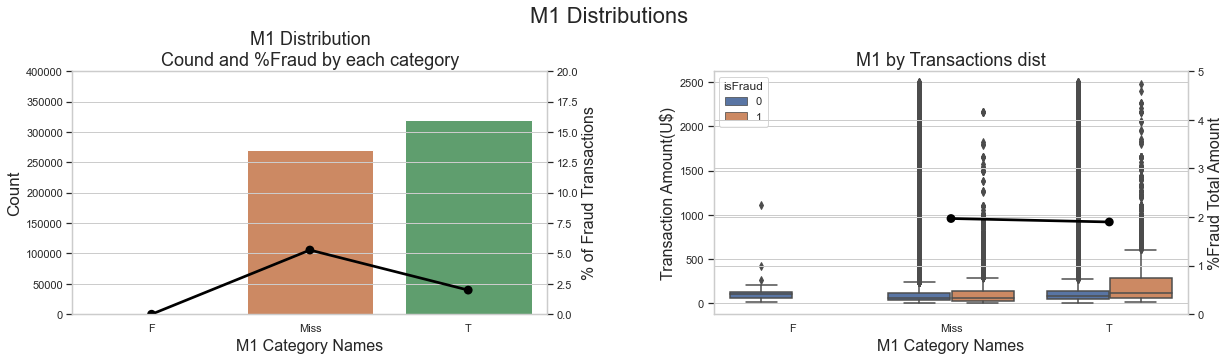

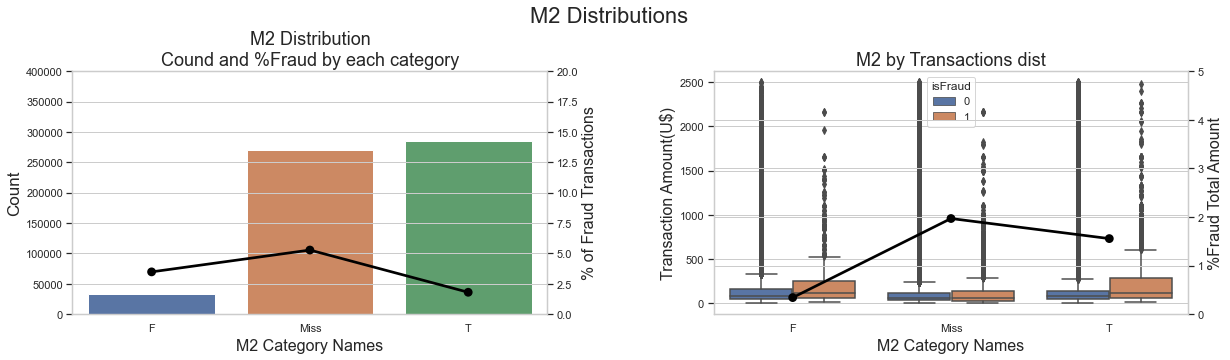

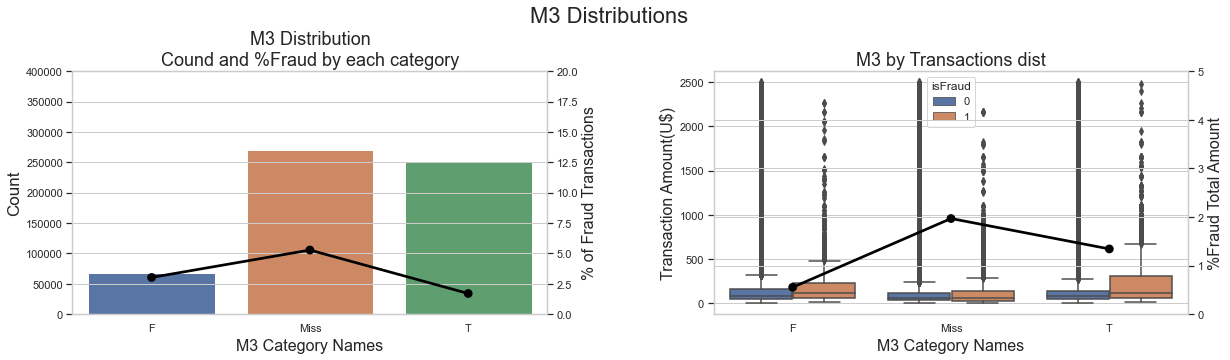

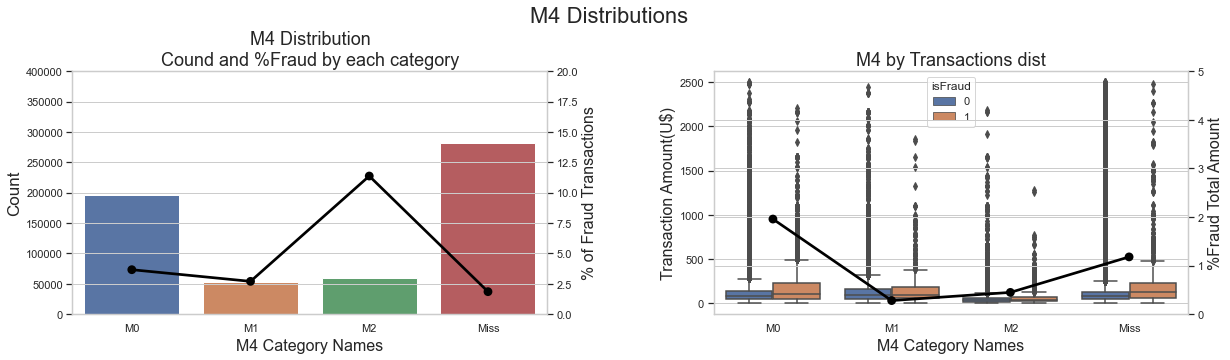

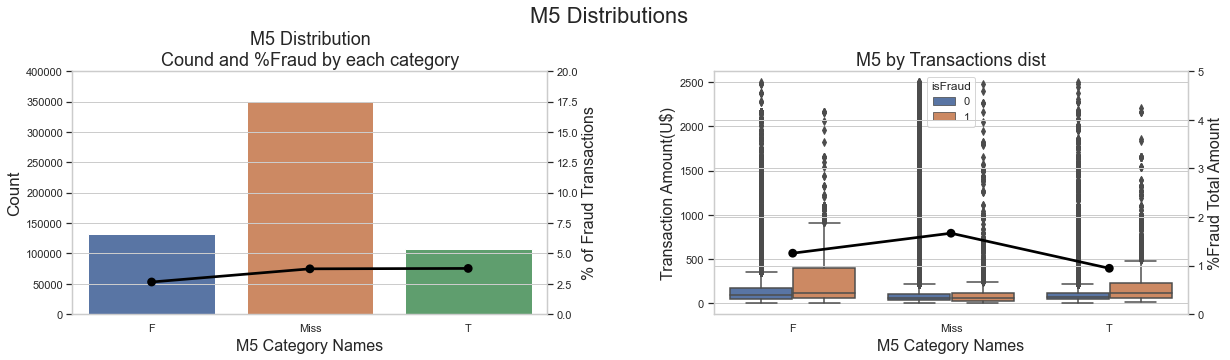

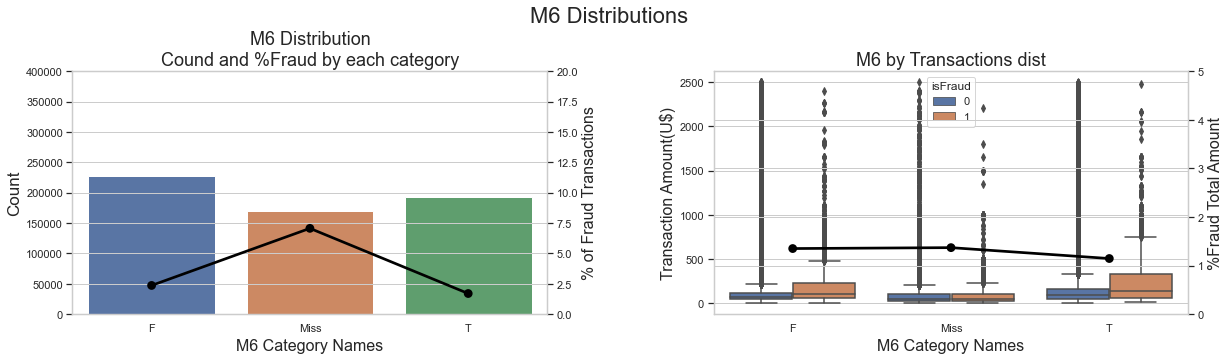

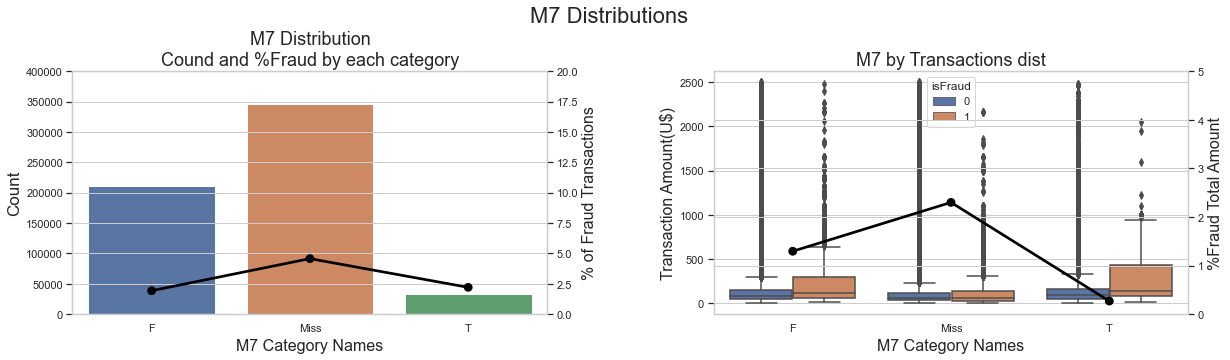

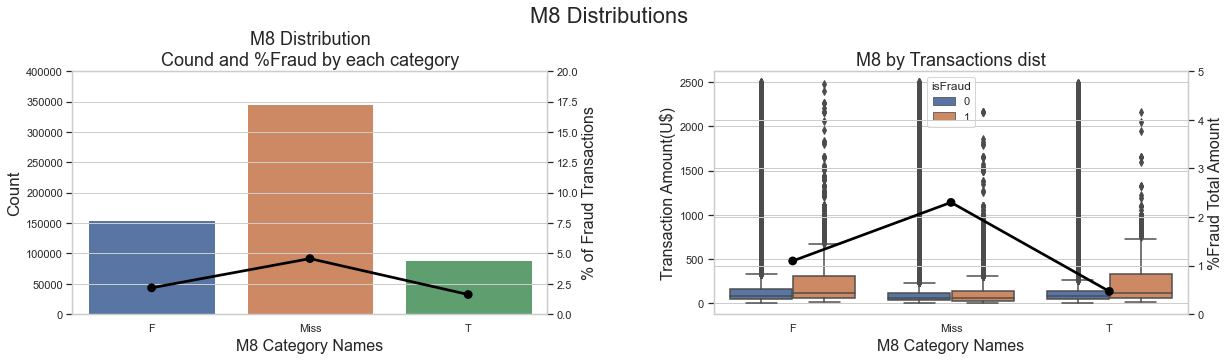

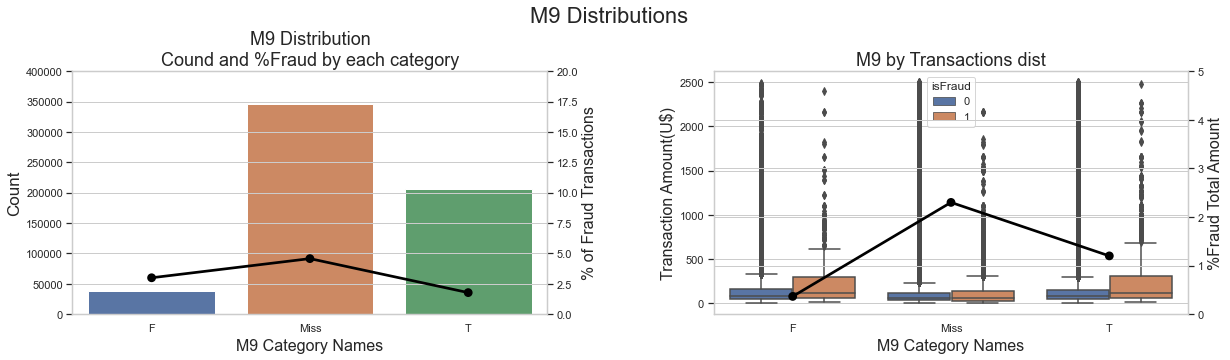

In [96]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(train, col, lim=2500)

In [84]:
train.M4.unique()

array(['M2', 'M0', nan, 'M1'], dtype=object)

#### V

In [70]:
v_cols = [v for v in train if v[0] == 'V']
train[v_cols]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
train[v_cols].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.072870,1.027704,1.041529,0.463915,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,0.007390,0.240133,0.320890,0.440053,0.475902,0.239385,0.304779,0.186069,0.226339,0.521522,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,8.000000,9.000000,6.000000,6.000000,9.000000,9.000000,8.000000,8.000000,4.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


In [72]:
V_count = round(train.iloc[:,55:394].isna().sum()/len(train),4)
for v, i in zip(V_count.index, V_count):
    print(v,i)

V1 0.4729
V2 0.4729
V3 0.4729
V4 0.4729
V5 0.4729
V6 0.4729
V7 0.4729
V8 0.4729
V9 0.4729
V10 0.4729
V11 0.4729
V12 0.1288
V13 0.1288
V14 0.1288
V15 0.1288
V16 0.1288
V17 0.1288
V18 0.1288
V19 0.1288
V20 0.1288
V21 0.1288
V22 0.1288
V23 0.1288
V24 0.1288
V25 0.1288
V26 0.1288
V27 0.1288
V28 0.1288
V29 0.1288
V30 0.1288
V31 0.1288
V32 0.1288
V33 0.1288
V34 0.1288
V35 0.2861
V36 0.2861
V37 0.2861
V38 0.2861
V39 0.2861
V40 0.2861
V41 0.2861
V42 0.2861
V43 0.2861
V44 0.2861
V45 0.2861
V46 0.2861
V47 0.2861
V48 0.2861
V49 0.2861
V50 0.2861
V51 0.2861
V52 0.2861
V53 0.1306
V54 0.1306
V55 0.1306
V56 0.1306
V57 0.1306
V58 0.1306
V59 0.1306
V60 0.1306
V61 0.1306
V62 0.1306
V63 0.1306
V64 0.1306
V65 0.1306
V66 0.1306
V67 0.1306
V68 0.1306
V69 0.1306
V70 0.1306
V71 0.1306
V72 0.1306
V73 0.1306
V74 0.1306
V75 0.151
V76 0.151
V77 0.151
V78 0.151
V79 0.151
V80 0.151
V81 0.151
V82 0.151
V83 0.151
V84 0.151
V85 0.151
V86 0.151
V87 0.151
V88 0.151
V89 0.151
V90 0.151
V91 0.151
V92 0.151
V93 0.151
V94 0

In [98]:
train[v_cols].corr()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
V1,1.000000,0.032168,0.024830,0.014216,0.013619,0.032284,0.026016,0.040820,0.034009,0.006574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V2,0.032168,1.000000,0.773039,0.318554,0.305504,0.621459,0.496921,0.732730,0.618591,0.036884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V3,0.024830,0.773039,1.000000,0.243684,0.353767,0.472570,0.546875,0.556536,0.653087,-0.005272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V4,0.014216,0.318554,0.243684,1.000000,0.915164,0.279596,0.221621,0.325873,0.273207,-0.013160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V5,0.013619,0.305504,0.353767,0.915164,1.000000,0.261490,0.294447,0.308716,0.354257,-0.035405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.647561,0.593782,0.647208,0.657350,0.703988,1.000000,0.914130,0.166021,0.552533,0.411911
V336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.412448,0.389508,0.410970,0.425812,0.906312,0.914130,1.000000,0.118221,0.353950,0.274392
V337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.245626,0.309989,0.259108,0.295698,0.041888,0.166021,0.118221,1.000000,0.742652,0.907378
V338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.780555,0.752075,0.800310,0.823754,0.054911,0.552533,0.353950,0.742652,1.000000,0.940009


 ----
 ----

In [73]:
# 메모리확보 위해 필요없는 변수 제거
del total_missing

### 'TransactionID'에 대해 유니크한 속성 개수 & 비율

In [74]:
# print(np.sum(train['TransactionID'].isin(train_id['TransactionID'].unique())))
# print(np.sum(test_transaction['TransactionID'].isin(test_id['TransactionID'].unique())))
print()
print(round(144233 / 590540 *100, 1), "% => 144233 / 590540 --TransactionIDs in train, have an associated train_identity")
print(round(141907 / 506692 *100, 1), "% => 141907 / 506692 --TransactionIDs in test, have an associated test_identity")


24.4 % => 144233 / 590540 --TransactionIDs in train, have an associated train_identity
28.0 % => 141907 / 506692 --TransactionIDs in test, have an associated test_identity


[데이터 확인 결과] NaN 과 마스킹 처리되어 어떤 정보인지 알 수 없는 column들이 많음 -> 전처리 진행 <br>
    - train_transaction : ``C1, C2 ... D1, V300, V339 ...``<br>
    - train_id : ``id_01 ... id_38``